In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import Policy, ema_logging

import pickle
import numpy as np

In [15]:
# Define the desired problem formulation here
pf = 3
model, _ = get_model_for_problem_formulation(pf)

In [3]:
#We do not understand yet why we need a reference_value, these values are from the std document of dike_model_simulation.py

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate 0': 3.5, 'discount rate 1': 3.5,
                    'discount rate 2': 3.5,
                    'ID flood wave shape': 4}
scen1 = {}
#comparing scenario's with the refference to select scenario's fitted for the problem
for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})
        
from ema_workbench import Scenario

ref_scenario = Scenario('reference', **scen1)

In [4]:
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

#The model is saving the convergence table every 500 nfr, so chose a large nomber to analhyse trends. 

nfe = 100000

#The amount of values for the epsilon list is dependend on the amount of outputs. 
#the larger you choose your epsilon, the more results you will get
#you could chose a lower epsilon in this case. 

epsilon = [2,2,2,2,2,2,2,2,2,2,2,2]   

#for now there is still a problem with the HyperVolume function. We could decide to not use it because the EpsilonProgress
#is also helpful findig the total amount of policies to establish the convergence of the policie space.

convergence_metrics = [HyperVolume(minimum=[0,0,0,0,0,0,0,0,0,0,0,0], maximum=[1.01, 1.01, 1.01, 1.01, 1.01, 1.01 ,1.01 ,1.01 ,1.01 ,1.01 , 1.01, 1.01]),
                       EpsilonProgress()]

#Run ones with Pickle is false to get results, then you could set Pickle on true to avoid unnesecery run time. =) 
use_pickle1 = True
if use_pickle1:
    with open(f"data/MORDM_results1_pf{pf}.pickle","rb") as filehandler:
        results, convergence = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  n_processes=10)
###!!!!!!
#Change the amount of processes accordingly. 10 processes is recommended for 6core CPU. 14 processes for 8 core CPU        
###!!!!!!
    #Save results in Pickle file
    with open(f"data/MORDM_results1_pf{pf}.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

In [5]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.0,0,0
1,0.0,83,100
2,0.0,512,1198
3,0.0,724,2290
4,0.0,914,3383
...,...,...,...
58,0.0,3600,92092
59,0.0,3617,93812
60,0.0,3639,95532
61,0.0,3660,97252


In [6]:
outcomes = results[list(model.outcomes.keys())]
outcomes.head()

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,7.643154e+07,0.000000,1.904505e+08,0.000000,4.089279e+06,0.003179,2.225849e+07,0.0,1.286831e+08,0.010206,6.506000e+08,1042.974731
1,7.222271e+07,0.000000,1.198616e+07,0.013818,6.500091e+07,0.000000,2.385018e+07,0.0,1.042954e+08,0.016323,8.947000e+08,0.000000
2,1.381680e+08,0.000000,1.208046e+07,0.001684,1.416977e+08,0.000000,6.320800e+06,0.0,2.503721e+07,0.000000,8.240000e+08,800.706996
3,3.269490e+07,0.000000,2.812492e+08,0.000000,0.000000e+00,0.000000,3.018556e+07,0.0,1.128116e+08,0.003773,1.112500e+09,345.345318
4,1.496842e+08,0.005854,8.732630e+06,0.001211,5.008175e+07,0.000000,1.854588e+07,0.0,8.579257e+07,0.001441,3.482000e+08,2372.069062


C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


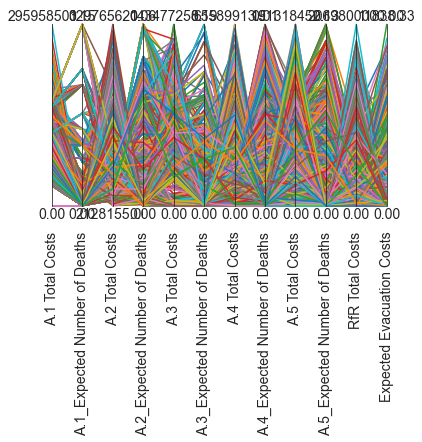

In [7]:
from ema_workbench.analysis import parcoords

#making a pairplot
import matplotlib.pyplot as plt

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.show()

In [8]:
convergence
#as seen, the hypervolume stays 0, this indicates an error. 

,hypervolume,epsilon_progress,nfe
0,0.0,0,0
1,0.0,83,100
2,0.0,512,1198
3,0.0,724,2290
4,0.0,914,3383
...,...,...,...
58,0.0,3600,92092
59,0.0,3617,93812
60,0.0,3639,95532
61,0.0,3660,97252


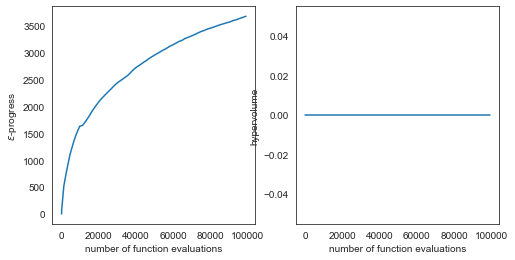

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Step 3: Re-evaluate candidate solutions under uncertainty

In [10]:
logical = results["A.3_Expected Number of Deaths"] <= 0
np.sum(logical)

503

In [11]:
results[logical].head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
1,0,1,1,0,0,0,1,1,1,1,...,1.198616e+07,0.013818,6.500091e+07,0.0,2.385018e+07,0.0,1.042954e+08,0.016323,8.947000e+08,0.000000
2,1,0,0,1,1,0,1,0,1,1,...,1.208046e+07,0.001684,1.416977e+08,0.0,6.320800e+06,0.0,2.503721e+07,0.000000,8.240000e+08,800.706996
3,1,1,0,0,1,0,1,1,1,0,...,2.812492e+08,0.000000,0.000000e+00,0.0,3.018556e+07,0.0,1.128116e+08,0.003773,1.112500e+09,345.345318
4,0,0,0,0,0,0,1,1,1,0,...,8.732630e+06,0.001211,5.008175e+07,0.0,1.854588e+07,0.0,8.579257e+07,0.001441,3.482000e+08,2372.069062
7,0,0,0,0,0,0,0,0,1,1,...,2.819300e+07,0.003870,9.312619e+07,0.0,0.000000e+00,0.0,2.503721e+07,0.000000,4.080000e+08,2821.551421


In [12]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1,0,1,1,0,0,0,1,1,1,1,...,0,1,1,2,2,3,1,0,6,6
2,1,0,0,1,1,0,1,0,1,1,...,0,6,7,10,1,0,0,0,1,0
3,1,1,0,0,1,0,1,1,1,0,...,10,0,0,0,7,6,0,1,7,1
4,0,0,0,0,0,0,1,1,1,0,...,0,1,0,5,5,1,0,0,3,6
7,0,0,0,0,0,0,0,0,1,1,...,0,3,4,6,0,0,0,0,1,0


In [13]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [14]:
#n_scenarios = 10
#with MultiprocessingEvaluator(model) as evaluator:
#    results2 = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)